In [18]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import scipy.stats as sts
import math
import os
import glob
import warnings
import numpy as np

In [32]:
def plot_all(dfs, key='Perf', name=''):
    n_runs = len(dfs)
    lines = []
    for df in dfs:
        value = df[key]
        line, = plt.plot(range(len(value)), value, label=name)
        lines.append(line)
    plt.xlabel('Iterations')
    plt.ylabel(key)
    return lines

def moments(dfs):
    cdf = pd.concat(dfs, sort=True).groupby(level=0)
    return cdf.mean(), cdf.std().fillna(0)
    
def plot_ci(dfs, key='Perf', conf=0.95, name='', step=1):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    x = list(range(len(mean)))
    mean = mean[1:-1:step]
    std = std_df[key][1:-1:step]
    
    line, = plt.plot(x[1:-1:step], mean, label=name)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/math.sqrt(n_runs))
    plt.fill_between(x[1:-1:step], interval[0], interval[1], alpha=0.3)
    return line

def load_all(name):
    return [pd.read_csv(file, index_col=False) for file in glob.glob("*.csv") if file.startswith(name + '_')]

def compare(env, names, keys=['Perf'], conf=0.95, logdir=None, separate=False, ymin=None, ymax=None, xmax=None, step=1):
    for key in keys:
        plt.figure()
        if ymin is not None and ymax is not None:
            plt.ylim(ymin, ymax)
        if xmax is not None:
            plt.xlim(0,xmax)
        if logdir is not None:
            os.chdir(logdir)
        handles = []
        for name in names:
            dfs = load_all(env + '_' + name)
            if separate:
                handles+=(plot_all(dfs, key, name))
            else:
                handles.append(plot_ci(dfs, key, conf, name, step))
        plt.legend(handles=handles)
        plt.show()

def save_csv(env, name, key, conf=0.95, path='.', rows=None, skip=100):
    dfs = load_all(env + '_' + name)
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key].values
    std = std_df[key].values + 1e-24
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/math.sqrt(n_runs))
    low, high = interval
    x = mean_df['BatchSize'].values
    x = np.cumsum(x) - x[0]
    if rows is not None:
        mean = mean[:rows:skip]
        low = low[:rows:skip]
        high = high[:rows:skip]
        x = x[:rows:skip]
    plotdf = pd.DataFrame({"Episodes": x, "Mean" : mean, "Low" : low, "High": high})
    plotdf.to_csv(path + '/' + env.lower() + '_' + name.lower() + '_' + key.lower() + '.csv', index=False, header=False)

# LQG SAFE

In [33]:
os.chdir('/home/matteo/policy-optimization/results/lqg_safe')
dfs = load_all('lqgd')

In [34]:
save_csv('lqgd', 'adastepgreedy', 'UPerf', path='/home/matteo/budget_paper/icml19/plots', rows=5000)
save_csv('lqgd', 'sepg', 'UPerf', path='/home/matteo/budget_paper/icml19/plots', rows=5000)
save_csv('lqgd', 'sepgbudget', 'UPerf', path='/home/matteo/budget_paper/icml19/plots', rows=5000)

save_csv('lqgd', 'adastepgreedydelta02', 'UPerf', path='/home/matteo/budget_paper/icml19/plots', rows=5000)
save_csv('lqgd', 'sepgdelta02', 'UPerf', path='/home/matteo/budget_paper/icml19/plots', rows=5000)
save_csv('lqgd', 'sepgbudgetdelta02', 'UPerf', path='/home/matteo/budget_paper/icml19/plots', rows=5000)
save_csv('lqgd', 'eternal', 'UPerf', path='/home/matteo/budget_paper/icml19/plots', rows=5000)

### All together

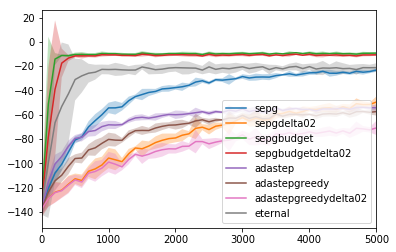

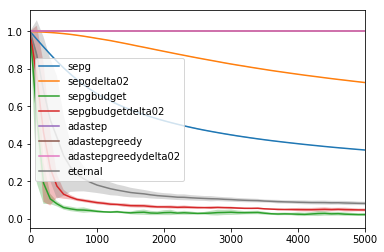

In [12]:
compare('lqgd', 
        ['sepg', 'sepgdelta02', 'sepgbudget', 'sepgbudgetdelta02', 'adastep', 'adastepgreedy', 'adastepgreedydelta02', 'eternal'], 
        ['UPerf','Exploration'],
        separate=False, conf=0.95, step=100, xmax=5000)